In [1]:
from Bio import SeqIO
import pandas as pd
import re
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# input FASTA file:
in_fasta = 'dlh'

# in and out paths
in_path = 'inputs/' + in_fasta + '.fasta.txt'
out_path = 'outputs/clean_' + in_fasta + '.fasta.txt'

In [3]:
# put sequences into a pandas dataframe
fasta_seqs = SeqIO.parse(open(in_path),'fasta')
data = []
for fasta in fasta_seqs:
    data.append([fasta.id, str(fasta.seq).strip()])
    
sequences_df = pd.DataFrame(data, columns = ['name', 'sequence'])

print('Total number of input sequences:', len(sequences_df))

sequences_df.head()

Total number of input sequences: 70110


,name,sequence
0,A0A009EPN2|IPR002925|21...241|DLH,MAAIKTREIQYTAQDGSTLIGYFAAPETDAPVAGVIVAPEWWGRND...
1,A0A009GF28|IPR002925|22...242|DLH,MSTAIKTREIQYTAPDGSHLIGYFAAPDSETPVAGVIVAPEWWGRN...
2,A0A009GFC1|IPR002925|16...232|Dienelactone,MAGQTIQIKTASGKQFSAYLATPETGKGPGVVLCQEIFGVNAAMRE...
3,A0A009GGE5|IPR002925|16...231|DLH,MAGQTVQIKTASGKQFSAYLATPETEKGPGVVLCQEIFGVNAAMRE...
4,A0A009H5J6|IPR002925|22...242|DLH,MSTAIKTREIQYTAPDGSHLIGYFAAPDSETPVAGVIVAPEWWGRN...


In [4]:
# remove sequences with length > 1000 AA's
rows2drop = []
for i in range(len(sequences_df)):
    if (len(sequences_df.sequence[i]) > 1000):
        rows2drop.append(i)

print('Total number of sequences dropped:', len(rows2drop))

sequences_df = sequences_df.drop(rows2drop).reset_index()

print('Total number of sequences remaining:', len(sequences_df))


Total number of sequences dropped: 231
Total number of sequences remaining: 69879


In [5]:
# remove sequences with invalid AA residues
#valid_alphabet = ['F','I','W','L','V','M','Y','C','A','T','H','G','S','Q','R','K','N','E','P','D']

def validate(seq, pattern=re.compile(r'^[FIWLVMYCATHGSQRKNEPD]+$')):
    if (pattern.match(seq)):
        return True
    return False

invalid_seqs = []

for i in range(len(sequences_df)):
    if (not validate(sequences_df.sequence[i])):
        invalid_seqs.append(i)
        
print('Total number of sequences dropped:', len(invalid_seqs))

sequences_df = sequences_df.drop(invalid_seqs).reset_index()

print('Total number of sequences remaining:', len(sequences_df))


Total number of sequences dropped: 852
Total number of sequences remaining: 69027


In [6]:
# save clean sequences as a .fasta.txt file
out_file = open(out_path, "w")
for i in range(len(sequences_df)):
    out_file.write('>' + sequences_df.name[i] + '\n')
    out_file.write(sequences_df.sequence[i] + '\n')
out_file.close()


In [7]:
# load target sequence

target_fasta = 'duraPETase'
target_path = 'inputs/' + target_fasta + '.fasta.txt'
target_seqs = SeqIO.parse(open(target_path),'fasta')
targets = []
for target in target_seqs:
    targets.append(str(target.seq).strip())
    
print(targets)


['MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPSGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTFDYPSSRSSQQMAALRQVASLNGDSSSPIYGKVDTARMGVMGHSMGGGASLRSAANNPSLKAAIPQAPWDSQTNFSSVTVPTLIFACENDSIAPVNSHALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTAVSDFRTANCS']


In [8]:
# calculate levenstein distance from chosen target sequence

distances = []
for i in range(len(sequences_df)):
    distances.append(distance(targets[0], sequences_df.sequence[i]))
distances = np.array(distances)

mean_dist = np.mean(distances)

print("Mean Levenstein distance:", mean_dist)


Mean Levenstein distance: 241.09273182957392


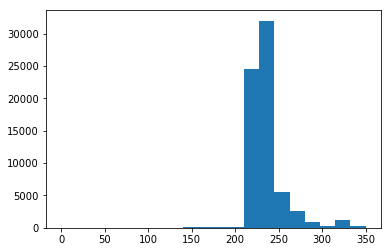

In [9]:
# histogram of Levenstein distances from target sequence
plt.clf()
plt.hist(distances, bins=20, range=(0,350))
plt.show()

In [10]:
# get the top 100 scores.
k = 100
idx = np.argpartition(distances, k)

closest_100 = []
closest_100_names = []
for i in range(k):
    closest_100.append(sequences_df.sequence[idx[i]])
    closest_100_names.append(sequences_df.name[idx[i]])

Mean Levenstein distance of closest 100 sequences: 151.42


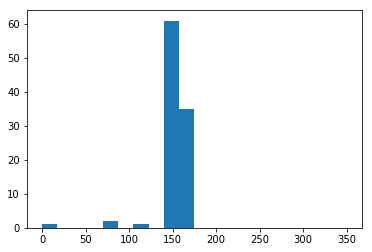

In [11]:
# verify they are indeed the top 100 scores.
plt.clf()
closest_100_dists = []
for i in range(len(closest_100)):
    closest_100_dists.append(distance(targets[0], closest_100[i]))
closest_100_dists = np.array(closest_100_dists)

mean__closest_100_dist = np.mean(closest_100_dists)
print("Mean Levenstein distance of closest 100 sequences:", mean__closest_100_dist)
plt.hist(closest_100_dists, bins=20, range=(0,350))
plt.show()


In [12]:
# save closest 100 sequences to target as a .fasta.txt file

out_path_2 = 'outputs/top_100_to_' + target_fasta + '.fasta.txt'

out_file = open(out_path_2, "w")
for i in range(len(closest_100)):
    out_file.write('>' + closest_100_names[i] + '\n')
    out_file.write(closest_100[i] + '\n')
out_file.close()


In [13]:
# load wild-type sequence

WT_fasta = 'isPETase'
WT_path = 'inputs/' + WT_fasta + '.fasta.txt'
WT_seqs = SeqIO.parse(open(WT_path),'fasta')
WTs = []
for WT in WT_seqs:
    WTs.append(str(WT.seq).strip())
    
print(WTs)


# save output for jackHMMer search (top 100 with target appended!) 

out_path_3 = 'outputs/jackHMMer_input.fasta.txt'

out_file = open(out_path_3, "w")
out_file.write('>' + WT_fasta + '\n')
out_file.write(WTs[0] + '\n')
for i in range(len(closest_100)):
    out_file.write('>' + closest_100_names[i] + '\n')
    out_file.write(closest_100[i] + '\n')
out_file.close()


['MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPSGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPSSRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAPQAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCS']
